In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from math import isnan
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import re

In [177]:
df = pd.read_csv('D:/Диплом_СмартТендер/ML_data_2021_2024.csv')

# df = pd.read_csv('ML_data_2021_2024.csv')

C:\Users\Misha\AppData\Local\Temp\ipykernel_15880\1109907890.py:1: DtypeWarning: Columns (4,8,14,15,24,28,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('D:/Диплом_СмартТендер/ML_data_2021_2024.csv')


# Модель под одного поставщика

## Логика

Отбираем одного поставщика, обучаемся на его истории участий и пытаемся предсказать с какой вероятностью он победит в тендере

Для примера, давай возьмем участия ТОВ "Епіцентр К", ЕГРПОУ - 32490244

In [44]:
print(f"Количество участий Епицентра в тендерах: {len(df[df.supplier_okpo == '32490244'])}")

Количество участий Епицентра в тендерах: 25955


## Features

Фичи, которые **точно не должны попасть** в трейн датасет для обучения:
- undoc
- idlot
- cdb_number
- lot_number
- lot_status
- tender_status
- organizer_norg
- organizer_okpo
- organizer_email
- organizer_name
- supplier_norg
- supplier_okpo
- supplier_email

Может из них можно извлечь какие-то фичи, но в том виде в котором они есть изначально их нельзя добавлять в трейн датасет

### EDA

При загрузке данных, нам лучше всегда заранее определять тип данных для наших колонок, так как у нас могут быть потом проблемы с данными, искажения в данных или mixed-types

In [8]:
df.groupby(['supplier_okpo','supplier_norg'], as_index=False)['undoc'].count().sort_values(by='undoc', ascending=False).head(20)

,supplier_okpo,supplier_norg,undoc
2,00000000,"Проєкт USAID «Безпечні, фінансово доступні та ...",41126
42882,32490244,"ТОВ ""Епіцентр К""",26954
73178,41449359,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ЛІВАЙ...",20604
9,0000000000,Mango-Guava Aquell water,19801
84753,43977041,"ТОВ ""ТВГ УКРАЇНСЬКИЙ ПАПІР""",18883
83984,43808856,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""СТМ-Ф...",16868
83597,43709245,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ЗБУТ-...",12620
7877,21633086,"ТОВ "" Медичний центр ""М.Т.К.""",12412
66920,39821153,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ІНТЕК...",11461
16791,25551379,"ТОВ ""Ромус-Поліграф""",11237


In [2]:
DATA_TYPES = {
    'undoc': 'int',
    'idlot': 'int',
    'lot_status': 'str',
    'payment_info': 'str',
    'cpv_code': 'str',
    'type_payment': 'str',
    'organizer_okpo': 'str',
    'supplier_okpo': 'str',
    'lot_title': 'str',
    'tender_title': 'str',
    'tender_description': 'str',
    'lot_amount': 'float',
    'lot_quantity': 'float',
    'guarantee': 'float',
    'price_offer_before_auction': 'float',
    'price_offer_after_auction': 'float'
}

DATE_COLS = ['date_publish', 'date_start_accept', 'date_end_accept',
             'date_auction', 'date_supply_from', 'date_supply_to']

df = pd.read_csv('D:/Диплом_СмартТендер/ML_data_2021_2024.csv', dtype=DATA_TYPES, parse_dates=DATE_COLS)

In [3]:
df.type_payment = df.type_payment.fillna('-')

In [4]:
def days_to_get_paid_calc(df):
    df['days_to_get_paid'] = df['payment_info'].str.extract('(\d+)')
    return df

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df = days_to_get_paid_calc(df)

In [7]:
def process_dataframe(df):
    # Create columns for prepayment, postpayment, prepayment_percentage, postpayment_percentage, and amount_of_splits
    df['prepayment'] = 0.0
    df['postpayment'] = 0.0
    df['prepayment_percentage'] = 0.0
    df['postpayment_percentage'] = 0.0
    df['amount_of_splits'] = 0

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        input_string = row['type_payment']  # Replace 'your_column_name' with the actual column name containing the strings
        # Use regex to find all pay types and percentages
        matches = re.findall(r'(\b\w+\b)\s+(\d+\.\d+%)', input_string)

        # Create dictionaries to store the sum of percentages and count of splits for each pay type
        pay_types_sums = {'prepayment': 0.0, 'postpayment': 0.0}
        pay_types_counts = {'prepayment': 0, 'postpayment': 0}
        prepayment = False
        postpayment = False
        # Accumulate percentages and count of splits for each pay type
        for pay_type, percentage in matches:
            if 'аванс' in pay_type.lower():
                prepayment = True
                pay_types_sums['prepayment'] += float(percentage[:-1])
                pay_types_counts['prepayment'] += 1
            elif 'пiсляоплата' in pay_type.lower():
                postpayment = True
                pay_types_sums['postpayment'] += float(percentage[:-1])
                pay_types_counts['postpayment'] += 1

        # Update the DataFrame with the calculated values
        df.at[index, 'prepayment'] = int(prepayment)
        df.at[index, 'postpayment'] = int(postpayment)
        df.at[index, 'prepayment_percentage'] = pay_types_sums['prepayment']  if prepayment else 0.0
        df.at[index, 'postpayment_percentage'] = pay_types_sums['postpayment']  if postpayment else 0.0
        df.at[index, 'amount_of_splits'] = pay_types_counts['prepayment'] + pay_types_counts['postpayment']

    return df

In [8]:
df = process_dataframe(df)

В дополнение к перечисленым выше фичам также убрал описание и название тендера, потому что с ними нет толку работать, они либо дублируют информацию из категории либо не несут информации вообще, и также сюда же вкинул цену после аукциона, поскольку этой инфы не будет до проведения тендера, а значит её не должно быть в трейне, плюс поле дисквалифицирован. 

In [9]:
clear_cols = df.columns[[0, 1, 2,3, 4,5, 6, 8, 9, 19, 25, 27, 29, 30, 33, 35, 37, 39]]
clear_cols

Index(['undoc', 'idlot', 'cbd_number', 'lot_number', 'lot_title',
       'tender_title', 'tender_description', 'lot_status', 'tender_status',
       'participation_cost', 'date_supply_from', 'organizer_norg',
       'organizer_email', 'organizer_name', 'supplier_norg', 'supplier_email',
       'price_offer_after_auction', 'disqualified'],
      dtype='object')

In [ ]:
# test_df = df[df['supplier_okpo'].isin(epic_df['organizer_okpo'])]
# test_df2 = test_df.value_counts().reset_index()
# test_df2 = test_df2[['supplier_okpo', 0]]
# epic_df.drop('supplier_okpo', axis=1)
# epic_df = pd.merge(epic_df, test_df2, left_on='organizer_okpo', right_on='supplier_okpo', how='left')

In [ ]:
epic_df

In [19]:
df = df.drop(clear_cols, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590491 entries, 0 to 2590490
Data columns (total 28 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   tender_procedure            object        
 1   lot_amount                  float64       
 2   tender_VAT                  int64         
 3   lot_quantity                float64       
 4   lot_measure                 object        
 5   payment_info                object        
 6   type_payment                object        
 7   guarantee                   float64       
 8   cpv_code                    object        
 9   category                    object        
 10  tender_buy_type             object        
 11  date_publish                datetime64[ns]
 12  date_start_accept           datetime64[ns]
 13  date_end_accept             datetime64[ns]
 14  date_auction                datetime64[ns]
 15  date_supply_to              object        
 16  organizer_okpo    

### Создать фичу days_to_deliver которая считает количевство дней с момента завершения подачи на тендер до для окончания поставок(date_supply_to), вместо пустых значений date_supply_to вписать среднее значение days_to deliver(ceil/floor)

Перед EDA нужно убрать участия в тех тендерах, где скрыты организатор и поставщик (с начала войны часть закупок скрывается)

Можно сбросить или по организатору или по поставщику

In [10]:
ORGANIZER_OKPO_TO_DROP = '00000000'
df = df[df['organizer_okpo'] != ORGANIZER_OKPO_TO_DROP]
df = df[df['supplier_okpo'] != ORGANIZER_OKPO_TO_DROP]

Отдельно по фичам:

- organizer_region
  
Возможно для Эпицентра такая фича не будет информативной, но в будущем для задачи предсказания победителя тендера, это будет информативная фича, так как поставщики часто хотят работать в своей области или соседней области из-за того что сумма тендера может не покрывать логистику.

Давай ниже проверим распределение поставщиков по уникальным областям (если область=null можем сбросить). Тут лучше сделать график

Посчитаем по ЕГРПОУ сколько у них уникальных областей и выведем к-ство уникальных ЕГРПОУ по к-ству областей.
То есть покажем, например, сколько участников участвовали только в одной уникальной области. Проверим ту гипотезу, которую я написал выше.

1. Для всех поставщиков и по всем участиям
2. Только для победителей (winner=1)
3. Отдельно для Епицентра (можно без графика, только цифру)

# Нет поля локация поставщика, брать самую частую из истории участий?

Все доступные кампаниии

<BarContainer object of 26 artists>

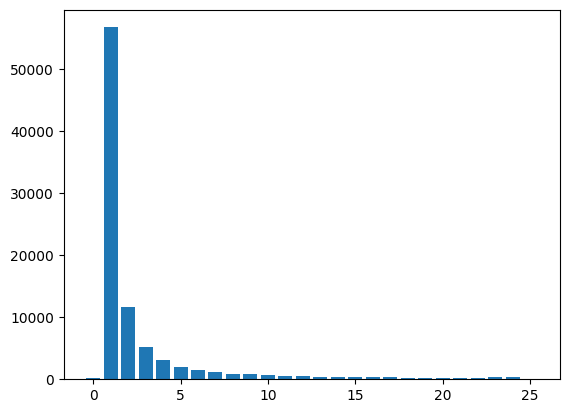

In [146]:
temp_df = df.groupby(['supplier_okpo']).nunique()
arr = list(np.unique(temp_df['organizer_region']))
vals = dict()
for i in arr:
    vals[i] = temp_df['organizer_region'][temp_df['organizer_region'] == i].count()
l = list(vals.values())
import matplotlib.pyplot as plt
plt.bar(range(0,26), l)

Только победители тендеров

<BarContainer object of 25 artists>

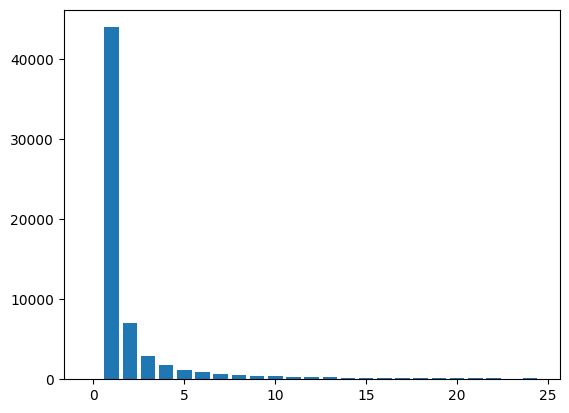

In [6]:
temp_df = df[df['winner'] == 1]
temp_df = temp_df.groupby(['supplier_okpo']).nunique()
arr = list(np.unique(temp_df['organizer_region']))
vals = dict()
for i in arr:
    vals[i] = temp_df['organizer_region'][temp_df['organizer_region'] == i].count()
l = list(vals.values())
import matplotlib.pyplot as plt
plt.bar(range(0,25), l)

In [16]:
epic_df = df[df['supplier_okpo'] == '32490244']
epic_df = epic_df.groupby(['supplier_okpo', 'organizer_region']).count()
epic_df['undoc']

supplier_okpo  organizer_region         
32490244       Івано-Франківська область     515
               Волинська область             545
               Вінницька область            1405
               Дніпропетровська область     1939
               Донецька область             1027
               Житомирська область           665
               Закарпатська область          346
               Запорізька область            962
               Київська область             9474
               Кіровоградська область        289
               Луганська область              86
               Львівська область            1418
               Миколаївська область          707
               Одеська область               675
               Полтавська область            827
               Рівненська область            694
               Сумська область               617
               Тернопільська область         277
               Харківська область            903
               Херсонська об

И еще посмотреть по категориям (но тут нужно их будет сократить до 2, 3 знака), к-ство участий по категориям, к-ство уникальных поставщиков по категориям, в разрезе всех участий, побед и только для Эпицентра

Нужно проверить нет ли у нас имбаланса по категориальным фичам

{1: 552, 2: 507, 3: 351, 4: 291, 5: 236, 6: 196, 7: 180, 8: 158, 9: 113, 10: 127, 11: 109, 12: 83, 13: 91, 14: 77, 15: 86, 16: 74, 17: 63, 18: 64, 19: 63, 20: 53, 21: 46, 22: 53, 23: 47, 24: 56, 25: 41, 26: 46, 27: 35, 28: 48, 29: 29, 30: 30, 31: 42, 32: 36, 33: 25, 34: 27, 35: 24, 36: 25, 37: 28, 38: 23, 39: 20, 40: 21, 41: 18, 42: 21, 43: 16, 44: 20, 45: 22, 46: 10, 47: 19, 48: 11, 49: 16, 50: 20, 51: 19, 52: 18, 53: 14, 54: 18, 55: 19, 56: 19, 57: 11, 58: 16, 59: 8, 60: 9, 61: 15, 62: 10, 63: 12, 64: 18, 65: 19, 66: 12, 67: 12, 68: 5, 69: 10, 70: 9, 71: 14, 72: 6, 73: 8, 74: 4, 75: 14, 76: 10, 77: 7, 78: 12, 79: 12, 80: 13, 81: 7, 82: 7, 83: 6, 84: 6, 85: 8, 86: 6, 87: 7, 88: 13, 89: 8, 90: 3, 91: 6, 92: 6, 93: 10, 94: 4, 95: 7, 96: 6, 97: 12, 98: 5, 99: 2, 100: 4, 101: 7, 102: 2, 103: 2, 104: 6, 105: 6, 106: 4, 107: 5, 108: 9, 109: 7, 110: 7, 111: 8, 112: 2, 113: 5, 114: 5, 115: 10, 116: 2, 117: 7, 118: 4, 119: 3, 120: 6, 121: 2, 122: 3, 123: 6, 124: 5, 125: 7, 126: 4, 127: 4, 128:

<BarContainer object of 496 artists>

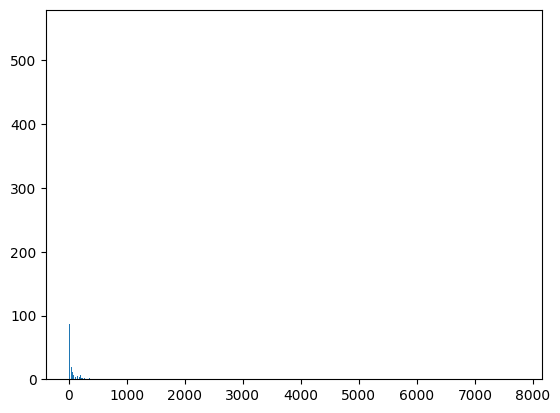

In [6]:
temp_df = df.groupby(['category']).nunique()
arr = list(np.unique(temp_df['supplier_okpo']))
vals = dict()
for i in arr:
    vals[i] = temp_df['supplier_okpo'][temp_df['supplier_okpo'] == i].count()
l = list(vals.values())
k = list(vals.keys())
print(vals)
import matplotlib.pyplot as plt
plt.bar(k, l)

Encoding Categorical Features

Давай напишем функции для разных типов кодирования категориальных фич (на примере Епицентра будем тестировать насколько это будет влиять на итоговый результат)

- Label Encoding
- One-Hot Encoding
- Dummy Encoding
- Effect Encoding (тут нужно подумать, подойдет ли этот метод для какой-то из фич, возможно его не нужно будет делать)

В функцию мы должны передавать или dataframe или колонку или список колонок, которые мы хотим перекодировать для модели.
Если хочешь, можешь сделать отдельный класс для Encoding и собрать там все методы, но это не обязательно.

In [61]:
from sklearn.preprocessing import LabelEncoder
class CategoricalEncoding:
    def __init__(self, dataframe, target_column):
        self.data = dataframe.copy()
        self.target_column = target_column

    def label_encoding(self):
        le = LabelEncoder()
        self.data[self.target_column] = le.fit_transform(self.data[self.target_column])
        return self.data

    def dummy_encoding(self):
        df_encoded = pd.get_dummies(self.data, columns=[self.target_column], prefix=[self.target_column], drop_first=True)
        return df_encoded

    def effect_encoding(self):
        unique_categories = self.data[self.target_column].unique()
        effect_encoded_values = {}
        for category in unique_categories:
            category_mean = self.data[self.data[self.target_column] == category]['target_variable'].mean()
            effect_encoded_values[category] = category_mean

        self.data[f'{self.target_column}_effect_encoded'] = self.data[self.target_column].map(effect_encoded_values)
        return self.data

def one_hot(dataframe, col_name):
    one_hot_encoded = pd.get_dummies(dataframe[col_name], prefix=col_name)
    dataframe = pd.concat([dataframe, one_hot_encoded], axis=1)
    return dataframe

In [63]:
epic_df['category']

788         2
794         2
3250       21
3255       21
3334       21
           ..
2590287    17
2590464    21
2590465    21
2590475    21
2590477    21
Name: category, Length: 25955, dtype: int64

Scaling Features

Так же и для int, float фич, возможно, нужна нормализация/стандартизация данных

- StandardScaler
- MinMax
- MaxAbs
- RobustScaler

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

class ColumnScaler:
    def __init__(self, dataframe):
        self.data = dataframe.copy()

    def scale_standard(self, columns_to_scale):
        scaler = StandardScaler()
        self.data[columns_to_scale] = scaler.fit_transform(self.data[columns_to_scale])
        return self.data

    def scale_minmax(self, columns_to_scale):
        scaler = MinMaxScaler()
        self.data[columns_to_scale] = scaler.fit_transform(self.data[columns_to_scale])
        return self.data

    def scale_maxabs(self, columns_to_scale):
        scaler = MaxAbsScaler()
        self.data[columns_to_scale] = scaler.fit_transform(self.data[columns_to_scale])
        return self.data

    def scale_robust(self, columns_to_scale):
        scaler = RobustScaler()
        self.data[columns_to_scale] = scaler.fit_transform(self.data[columns_to_scale])
        return self.data

NaN handling

По фичам, которые у нас могут быть NaN, тоже нужно продумать логику, как их обрабатывать
В sklearn есть отдельный модуль Impute, посмотри есть ли там какие-то методы, которые могут помочь нам не урезать наш набор данных и не сбрасывать NaN или создавать под NaN отдельную категорию


In [23]:
epic_df.isnull().sum()

NameError: name 'epic_df' is not defined

In [ ]:
df['payment_info'].str.extract('(\d+)')

In [14]:
c_epic_df = epic_df.reset_index()
days_to_deliver = []
c_epic_df['date_supply_to'][2660] = '2021-04-30 01:00:00.000'
c_epic_df['date_supply_to'][2661] = '2021-04-30 01:00:00.000'
for i in range(c_epic_df.shape[0]):
    if(c_epic_df['date_supply_to'].notna()[i]):
        days_to_deliver.append((pd.to_datetime(c_epic_df['date_supply_to'][i])-c_epic_df['date_end_accept'][i]).days)
    else:
        days_to_deliver.append(90)

NameError: name 'epic_df' is not defined

In [81]:
epic_df['days_to_deliver']

788        349
794        349
3250       106
3255       106
3334       345
          ... 
2590287    191
2590464    345
2590465    345
2590475    345
2590477    345
Name: days_to_deliver, Length: 26954, dtype: int64

Переделать фичу Категория

Как можно разложить фичу категории

Берем только первые 8 цифр, из них:

Первые две - направление (строительство, медицина, продукты питания и т.д.)

Все что ниже уже характеризирует конкретное направление.

Примеры:
09310000-5 Електрична енергія

Если мы возьмем и разложим данную категорию

09000000-3 Нафтопродукти, паливо, електроенергія та інші джерела енергії -> 09300000-2 Електрична, теплова, сонячна та атомна енергія ->
09310000-5 Електрична енергія

Категорию можно разложить после второго, третьего, четвертого и до пятого знака, пока не встретится в ней число 0

Но на практике дальше 4 четвертого знака заходить уже нет смысла. По этому второй/третий я бы брал. Возможно придумать какую-то особенную фичу


Была 1 запись с cpv_code равным 91, её выкинул

In [149]:
np.unique(df['cpv_code'].str.slice(0,2))

array(['03', '09', '14', '15', '16', '18', '19', '22', '24', '30', '31',
       '32', '33', '34', '35', '37', '38', '39', '41', '42', '43', '44',
       '45', '48', '50', '51', '55', '60', '63', '64', '65', '66', '70',
       '71', '72', '73', '75', '76', '77', '79', '80', '85', '90', '91',
       '92', '98', '99'], dtype=object)

In [13]:
df = df[df['cpv_code'] != '91']

In [158]:
categories, sub_categories, subsub_categories = [],[],[]
for i in df['cpv_code']:
    categories.append(int((i)[:2]))
    sub_categories.append(int((i)[2]))
    subsub_categories.append(int((i)[3]))
df['category'] = categories
df['sub_category'] = sub_categories
df['subsub_category'] = subsub_categories

In [160]:
set(categories)

{3,
 9,
 14,
 15,
 16,
 18,
 19,
 22,
 24,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 48,
 50,
 51,
 55,
 60,
 63,
 64,
 65,
 66,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 79,
 80,
 85,
 90,
 92,
 98,
 99}

Гарантия как категориальная фича ???

Проверить гипотезу, что гарантию лучше использовать как категориальную фичу

Если сумма заполнена = есть гарантия

In [51]:
guarantees = [False if (isnan(x) or int(x) == 0) else True for x in df['guarantee']]
df['guarantee'] = guarantees

Посмотреть итоговую корреляцию фичей. Фичи у которых сильная корелляция - дропнуть

C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\1582721150.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(epic_df.corr())


<Axes: >

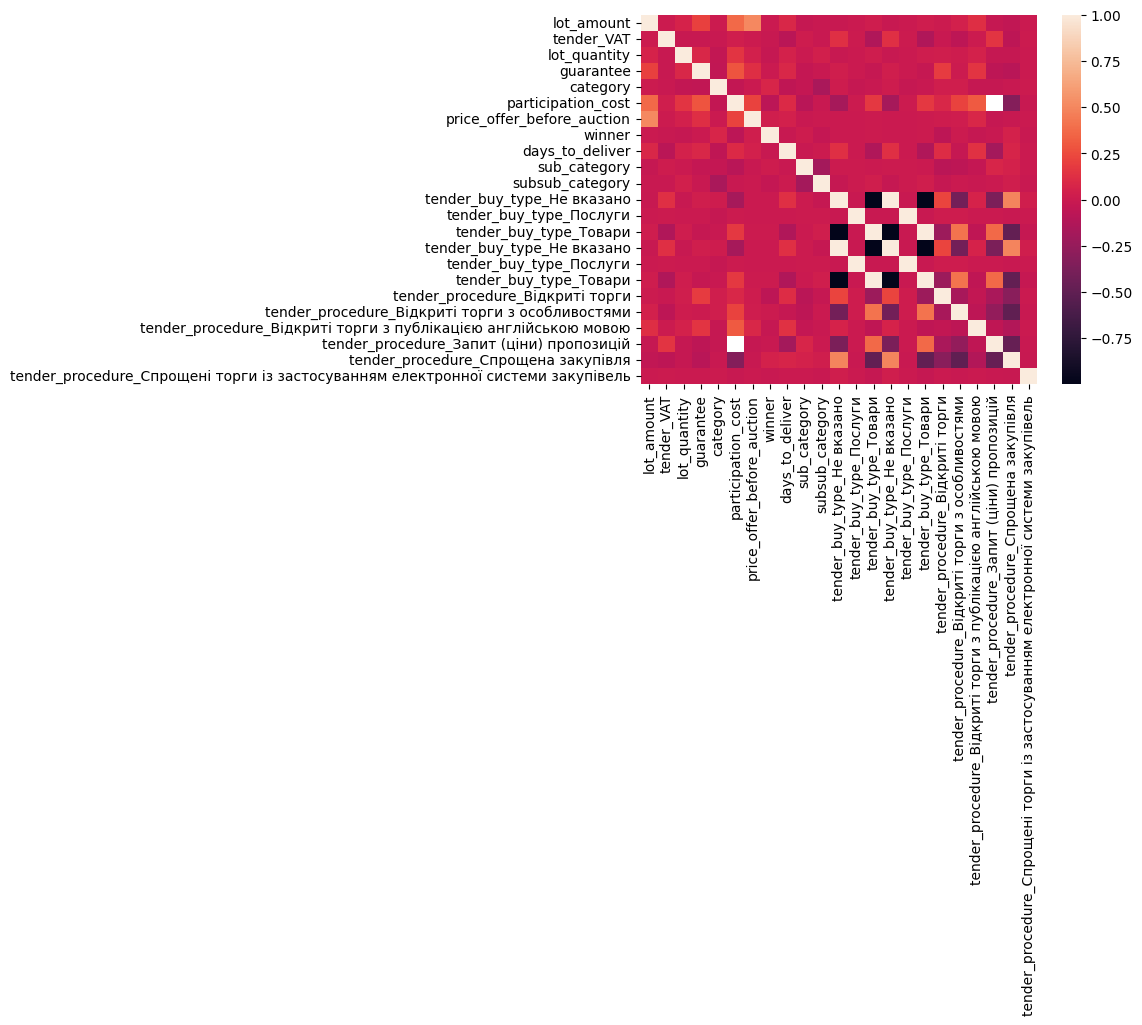

In [108]:
import seaborn as sns
sns.heatmap(epic_df.corr())

Реализовать кастомный train_test_split или KFold.

Логика в том что, мы не можем просто рандомно отбирать данные для обучения и валидации, так как модель должна обучаться на данных отсортированных по дате.

Условно - обучаемся на 2021, 2022 и 3 месяцах 2023 года, остальные 9 месяцев 2023 года для валидации.

In [14]:
epic_df = df[df['supplier_okpo']=='32490244']
# epic_df_train = epic_df[epic_df['date_publish'] < pd.to_datetime('2023-02-28')]
# epic_df_test = epic_df[epic_df['date_publish'] >= pd.to_datetime('2023-02-28')]

Добавление фичи с днями на доставку, NaN заменяю заранее расчитаным средним значеннием 

In [17]:
c_epic_df[c_epic_df['date_supply_to'] == '3021-04-30 01:00:00.000']

,index,undoc,idlot,cbd_number,lot_number,lot_title,tender_title,tender_description,tender_procedure,lot_status,tender_status,lot_amount,tender_VAT,lot_quantity,lot_measure,payment_info,type_payment,guarantee,cpv_code,category,participation_cost,tender_buy_type,date_publish,date_start_accept,date_end_accept,date_auction,date_supply_from,date_supply_to,organizer_norg,organizer_okpo,organizer_email,organizer_name,organizer_region,organizer_city,supplier_norg,supplier_okpo,supplier_email,price_offer_before_auction,price_offer_after_auction,winner,disqualified,days_to_get_paid,prepayment,postpayment,prepayment_percentage,postpayment_percentage,amount_of_splits
2504,308078,18409860,9930144,UA-2021-03-23-004509-a,1,NaN,"ДК 021:2015 «33710000-0» - Парфуми, засоби гіг...",NaN,Спрощена закупівля,NaN,Завершено,72000.0,1,3942.0,шт,7 Банківських днів\r,Пiсляоплата 100.0%\r,NaN,33710000-0,"Парфуми, засоби гігієни та презервативи",340.0,NaN,2021-03-23 11:55:49,2021-03-29 09:00:00,2021-04-01 09:00:00,2021-04-02 15:49:47,NaN,3021-04-30 01:00:00.000,"ВИЩИЙ ДЕРЖАВНИЙ НАВЧАЛЬНИЙ ЗАКЛАД УКРАЇНИ ""УКР...",02010824,gridina@umsa.edu.ua,Анна Грідіна,Полтавська область,Полтава,"ТОВ ""Епіцентр К""",32490244,PL.TENDER@EPICENTRK.COM,0.00,49182.96,0,0,7,0.0,1.0,0.0,100.0,1
2505,308081,18409860,9930144,UA-2021-03-23-004509-a,1,NaN,"ДК 021:2015 «33710000-0» - Парфуми, засоби гіг...",NaN,Спрощена закупівля,NaN,Завершено,72000.0,1,3942.0,шт,7 Банківських днів\r,Пiсляоплата 100.0%\r,NaN,33710000-0,"Парфуми, засоби гігієни та презервативи",340.0,NaN,2021-03-23 11:55:49,2021-03-29 09:00:00,2021-04-01 09:00:00,2021-04-02 15:49:47,NaN,3021-04-30 01:00:00.000,"ВИЩИЙ ДЕРЖАВНИЙ НАВЧАЛЬНИЙ ЗАКЛАД УКРАЇНИ ""УКР...",02010824,gridina@umsa.edu.ua,Анна Грідіна,Полтавська область,Полтава,"ТОВ ""Епіцентр К""",32490244,PL.TENDER@EPICENTRK.COM,49182.96,47398.00,0,1,7,0.0,1.0,0.0,100.0,1


In [18]:
c_epic_df = epic_df.reset_index()
days_to_deliver = []
c_epic_df['date_supply_to'][2504] = '2021-04-30 01:00:00.000'
c_epic_df['date_supply_to'][2505] = '2021-04-30 01:00:00.000'
print(c_epic_df[c_epic_df['date_supply_to'] == '3111-01-01 02:00:00.000'])
for i in range(c_epic_df.shape[0]):
    if(c_epic_df['date_supply_to'].notna()[i]):
        days_to_deliver.append((pd.to_datetime(c_epic_df['date_supply_to'][i])-c_epic_df['date_end_accept'][i]).days)
    else:
        days_to_deliver.append(90)
epic_df['days_to_deliver'] = days_to_deliver

C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\460408641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_epic_df['date_supply_to'][2504] = '2021-04-30 01:00:00.000'
C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\460408641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_epic_df['date_supply_to'][2505] = '2021-04-30 01:00:00.000'


Empty DataFrame
Columns: [index, undoc, idlot, cbd_number, lot_number, lot_title, tender_title, tender_description, tender_procedure, lot_status, tender_status, lot_amount, tender_VAT, lot_quantity, lot_measure, payment_info, type_payment, guarantee, cpv_code, category, participation_cost, tender_buy_type, date_publish, date_start_accept, date_end_accept, date_auction, date_supply_from, date_supply_to, organizer_norg, organizer_okpo, organizer_email, organizer_name, organizer_region, organizer_city, supplier_norg, supplier_okpo, supplier_email, price_offer_before_auction, price_offer_after_auction, winner, disqualified, days_to_get_paid, prepayment, postpayment, prepayment_percentage, postpayment_percentage, amount_of_splits]
Index: []


C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\460408641.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['days_to_deliver'] = days_to_deliver


Обрабатываю поле cpv_code, создаю 3 новых фичи вместо него

In [19]:
categories, sub_categories, subsub_categories = [],[],[]
for i in epic_df['cpv_code']:
    categories.append(int((i)[:2]))
epic_df['category'] = categories

C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\3288278780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['category'] = categories


In [20]:
epic_df['category_participation count'] = epic_df.groupby('category').cumcount()

C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\1883573208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['category_participation count'] = epic_df.groupby('category').cumcount()


In [21]:
guarantees = [False if (isnan(x) or int(x) == 0) else True for x in epic_df['guarantee']]
epic_df['guarantee'] = guarantees

C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\983640462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['guarantee'] = guarantees


Для поля tender_buy_type в котором содержится 10000 пустых записей, а информативность оно все таки несет, то я не вижу другого выхода как создать доп категорию для NaN, и применить one-hot encoding

In [98]:
epic_df.drop(['tender_buy_type_Не вказано', 'tender_buy_type_Послуги', 'tender_buy_type_Товари'],axis=1)

,tender_procedure,lot_amount,tender_VAT,lot_quantity,lot_measure,payment_info,type_payment,guarantee,cpv_code,category,...,date_supply_to,organizer_okpo,organizer_region,organizer_city,supplier_okpo,price_offer_before_auction,winner,days_to_deliver,sub_category,subsub_category
788,Спрощена закупівля,3000000.0,1,5800.0,м³,90 Календарних днів\r,Пiсляоплата 100.0%\r,False,14210000-6,14,...,2021-12-31 00:00:00.000,03349022,Львівська область,Львів,32490244,0.0,0,349,2,1
794,Спрощена закупівля,3000000.0,1,5800.0,м³,90 Календарних днів\r,Пiсляоплата 100.0%\r,False,14210000-6,14,...,2021-12-31 00:00:00.000,03349022,Львівська область,Львів,32490244,2994774.0,0,349,2,1
3250,Спрощена закупівля,98690.0,0,1950.0,шт,30 Календарних днів\r,Пiсляоплата 100.0%\r,False,44110000-4,44,...,2021-05-01 00:00:00.000,14310052,Харківська область,Харків,32490244,0.0,0,106,1,1
3255,Спрощена закупівля,98690.0,0,1950.0,шт,30 Календарних днів\r,Пiсляоплата 100.0%\r,False,44110000-4,44,...,2021-05-01 00:00:00.000,14310052,Харківська область,Харків,32490244,72000.0,1,106,1,1
3334,Відкриті торги,146000.0,1,1.0,лот,30 Календарних днів\r,Пiсляоплата 100.0%\r,False,44110000-4,44,...,2021-12-31 15:56:49.000,03327121,Запорізька область,ЗАПОРІЖЖЯ,32490244,104640.0,0,345,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590287,Запит (ціни) пропозицій,2248.0,1,2.0,шт,NaN,NaN,False,39710000-2,39,...,2024-07-31 15:49:13.000,03357168,Черкаська область,Черкаси,32490244,0.0,1,191,7,1
2590464,Запит (ціни) пропозицій,1800.0,1,3.6,м²,NaN,NaN,False,44110000-4,44,...,2024-12-31 00:00:00.000,02071100,Полтавська область,Полтава,32490244,0.0,1,345,1,1
2590465,Запит (ціни) пропозицій,1800.0,1,3.6,м²,NaN,NaN,False,44110000-4,44,...,2024-12-31 00:00:00.000,02071100,Полтавська область,Полтава,32490244,0.0,0,345,1,1
2590475,Запит (ціни) пропозицій,3500.0,1,250.0,кг,NaN,NaN,False,44110000-4,44,...,2024-12-31 00:00:00.000,02071100,Полтавська область,Полтава,32490244,0.0,0,345,1,1


In [26]:
print(epic_df.loc[~epic_df['tender_procedure'].isin(['Запит (ціни) пропозицій','Спрощена закупівля']), 'tender_procedure'] = 'Інше')

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3192642540.py, line 1)

In [27]:
epic_df['tender_buy_type']=epic_df['tender_buy_type'].fillna('Не вказано')
epic_df = one_hot(epic_df, 'tender_buy_type')
epic_df = one_hot(epic_df, 'tender_procedure')
enc = CategoricalEncoding(epic_df, 'category')
epic_df = enc.label_encoding()

C:\Users\Misha\AppData\Local\Temp\ipykernel_17008\1815352215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['tender_buy_type']=epic_df['tender_buy_type'].fillna('Не вказано')


In [28]:
epic_df = epic_df.drop(['tender_buy_type', 'cpv_code', 'tender_procedure', 'date_supply_to', 'supplier_okpo', 'lot_measure', 'payment_info', 'type_payment', 'organizer_city', 'organizer_region', 'organizer_okpo'], axis=1)

In [29]:
epic_df.days_to_get_paid = epic_df.days_to_get_paid.fillna(-1)

In [30]:
epic_df.days_to_get_paid = pd.to_numeric(epic_df.days_to_get_paid)

In [64]:
epic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25955 entries, 788 to 2590477
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   lot_amount                                25955 non-null  float64       
 1   tender_VAT                                25955 non-null  int64         
 2   lot_quantity                              25955 non-null  float64       
 3   guarantee                                 25955 non-null  bool          
 4   category                                  25955 non-null  int64         
 5   date_publish                              25955 non-null  datetime64[ns]
 6   date_start_accept                         25955 non-null  datetime64[ns]
 7   date_end_accept                           25955 non-null  datetime64[ns]
 8   date_auction                              19075 non-null  datetime64[ns]
 9   price_offer_before_aucti

In [32]:
epic_df = epic_df.drop(clear_cols, axis=1)

In [65]:
epic_df_train = epic_df[epic_df['date_publish'] < pd.to_datetime('2023-06-28')]
epic_df_test = epic_df[epic_df['date_publish'] >= pd.to_datetime('2023-06-28')]

In [66]:
y_train = epic_df_train['winner']
X_train = epic_df_train.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish','winner'], axis=1)
y_test = epic_df_test['winner']
X_test = epic_df_test.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish','winner'], axis=1)

Инициализация моделей:

Модели, которые можно применить и которые считаются наиболее эффективными в таких задачах:

- XGBoost
- LightGBM
- Neural Network (Keras, TensorFlow, PyTorch)
- Ensemble models (XGBoost + LightGBM)

В scikit-learn тоже есть еще какие-то модели, если захочешь можешь и оттуда взять еще какие-то, по типу KNN, SVM и другие

Подбор гиперпараметров к моделям:

Модуль - hyperopt или другой какой-то

Для scikit-learn - GridSearchCV и вроде RandomGridSearchCV

Для моделей нужно будет подобрать правильные гиперпараметры.


In [224]:
# epic_df = epic_df.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish'], axis=1)

In [35]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [48]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def xgb_objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        objective='binary:logistic',
        eval_metric='logloss'
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = -roc_auc_score(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK}

# Define hyperparameter search space for XGBoost
xgb_space = {
    'n_estimators': hp.uniform('n_estimators', 10, 400),
    'max_depth': hp.uniform('max_depth', 3, 12),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.05),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

# Define objective function for LightGBM
def lgb_objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        reg_alpha=params['reg_alpha'],
        objective='binary',
        metric='binary_logloss'
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = -roc_auc_score(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK}

lgb_space = {
    'n_estimators': hp.uniform('n_estimators', 50, 500),
    'max_depth': hp.uniform('max_depth', 3, 10),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.05),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.5)
}

xgb_trials = Trials()
lgb_trials = Trials()

# Optimize XGBoost hyperparameters
xgb_best = fmin(fn=xgb_objective, space=xgb_space, algo=tpe.suggest, max_evals=50, trials=xgb_trials, verbose=False)

# Optimize LightGBM hyperparameters
lgb_best = fmin(fn=lgb_objective, space=lgb_space, algo=tpe.suggest, max_evals=50, trials=lgb_trials, verbose=False)

# Print the best hyperparameters for XGBoost and LightGBM
print("Best XGBoost hyperparameters:", xgb_best)
print("Best LightGBM hyperparameters:", lgb_best)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start training from score -1.336037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start training from score -1.336037
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > nu

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start training from score -1.336037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start training from score -1.336037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [49]:
class Ensemble:
    def __init__(self, params):
        self.lgb_params = params['lgb_params']
        self.xgb_params = params['xgb_params']
        
        self.lgb_model = LGBMClassifier(**self.lgb_params)
        self.xgb_model = XGBClassifier(**self.xgb_params)
        
    def fit(self, X, y):
        return (self.lgb_model.fit(X, y), self.xgb_model.fit(X, y))
    
    def predict(self, X, weights=[1, 1], threshold=0.5):
        ensemble_score = (self.lgb_model.predict(X) * weights[0] + self.xgb_model.predict(X) * weights[1]) / 2
        return np.where(ensemble_score >= threshold, 1, 0)

In [50]:
xgb_best['n_estimators'] = int(xgb_best['n_estimators'])
lgb_best['n_estimators'] = int(lgb_best['n_estimators'])
xgb_best['max_depth'] = int(xgb_best['max_depth'])
lgb_best['max_depth'] = int(lgb_best['max_depth'])
xgc = XGBClassifier(n_estimators=xgb_best['n_estimators'],
        max_depth=int(xgb_best['max_depth']),
        learning_rate=0.1,
        subsample=xgb_best['subsample'],
        colsample_bytree=xgb_best['colsample_bytree'],
        objective='binary:hinge',
        eval_metric='logloss')
lbg = LGBMClassifier(n_estimators=lgb_best['n_estimators'],
        max_depth=int(lgb_best['max_depth']),
        learning_rate=0.1,
        subsample=lgb_best['subsample'],
        colsample_bytree=lgb_best['colsample_bytree'],
        reg_alpha=lgb_best['reg_alpha'],
        objective='binary',
        metric='binary_logloss')
params = {'lgb_params': lgb_best, 'xgb_params': xgb_best}
model_ens = Ensemble(params)

ROC AUC:  0.5095254967222067
F1 score:  0.06811145510835913
Accuracy:  0.8020171015128261
Precision:  0.3188405797101449
Recall:  0.038128249566724434
lot_amount  :  0.032937888
tender_VAT  :  0.039952274
lot_quantity  :  0.03261916
guarantee  :  0.082379505
category  :  0.06180642
price_offer_before_auction  :  0.16476849
days_to_get_paid  :  0.03351517
prepayment  :  0.03129923
postpayment  :  0.0
prepayment_percentage  :  0.019794969
postpayment_percentage  :  0.024503408
amount_of_splits  :  0.059557304
days_to_deliver  :  0.031463344
category_participation count  :  0.043012224
tender_buy_type_Не вказано  :  0.03419819
tender_buy_type_Послуги  :  0.0
tender_buy_type_Товари  :  0.16818178
tender_procedure_Інше  :  0.057812247
tender_procedure_Запит (ціни) пропозицій  :  0.0
tender_procedure_Спрощена закупівля  :  0.08219839


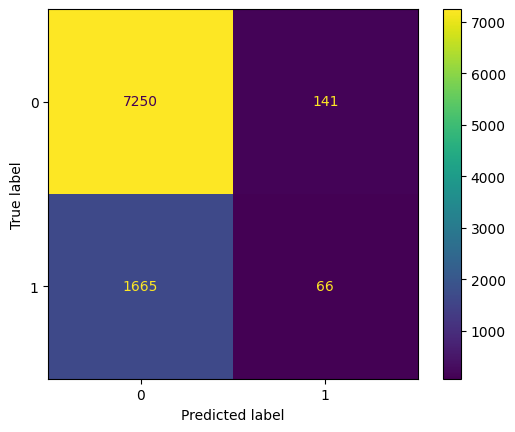

In [51]:
xgb_test = XGBClassifier()
xgb_test.fit(X_train, y_train)
preds = xgb_test.predict(X_test)
roc = roc_auc_score(y_test, preds)
prec = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print('ROC AUC: ', roc)
print('F1 score: ', f1)
print('Accuracy: ', accuracy)
print('Precision: ', prec)
print('Recall: ', recall)
cm = confusion_matrix(y_test, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
for i in range(len(xgb_test.feature_names_in_)):
    print(xgb_test.feature_names_in_[i],' : ',xgb_test.feature_importances_[i])

ROC AUC:  0.5503843613256743
F1 score:  0.27720065609622746
Accuracy:  0.7101512826134619
Precision:  0.26310326933056566
Recall:  0.292894280762565
lot_amount  :  0.036881957
tender_VAT  :  0.03716925
lot_quantity  :  0.046496335
guarantee  :  0.036789224
category  :  0.054477863
price_offer_before_auction  :  0.1093755
days_to_get_paid  :  0.04601401
prepayment  :  0.048847776
postpayment  :  0.038435876
prepayment_percentage  :  0.044727925
postpayment_percentage  :  0.058754325
amount_of_splits  :  0.06357507
days_to_deliver  :  0.050187074
category_participation count  :  0.045042224
tender_buy_type_Не вказано  :  0.053809673
tender_buy_type_Послуги  :  0.0
tender_buy_type_Товари  :  0.063859314
tender_procedure_Інше  :  0.063748345
tender_procedure_Запит (ціни) пропозицій  :  0.0
tender_procedure_Спрощена закупівля  :  0.10180826


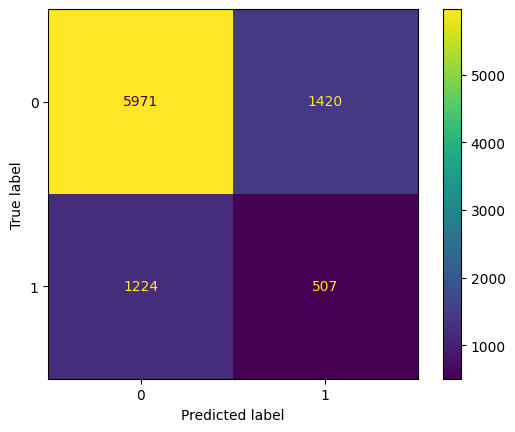

In [52]:
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
roc = roc_auc_score(y_test, preds)
prec = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print('ROC AUC: ', roc)
print('F1 score: ', f1)
print('Accuracy: ', accuracy)
print('Precision: ', prec)
print('Recall: ', recall)
cm = confusion_matrix(y_test, preds, labels=xgc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgc.classes_)
disp.plot()
for i in range(len(xgc.feature_names_in_)):
    print(xgc.feature_names_in_[i],' : ',xgc.feature_importances_[i])

In [53]:
lbg.fit(X_train, y_train)
preds = lbg.predict(X_test)
roc = roc_auc_score(y_test, preds)
prec = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print('ROC AUC: ', roc)
print('F1 score: ', f1)
print('Accuracy: ', accuracy)
print('Precision: ', prec)
print('Recall: ', recall)
for i in range(len(lbg.feature_name_)):
    print(lbg.feature_name_[i],' : ',lbg.feature_importances_[i])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start training from score -1.336037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [54]:
model_ens.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 13329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 16833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208163 -> initscore=-1.336037
[LightGBM] [Info] Start training from score -1.336037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

(LGBMClassifier(colsample_bytree=0.8070252334488909,
                learning_rate=0.04584979517514623, max_depth=9, n_estimators=331,
                reg_alpha=0.3589017589184606, subsample=0.8212628673925283),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9629724433047304, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.03735815188979884,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=11, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=404, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ROC AUC:  0.5342826822416853
F1 score:  0.1769834350479512
Accuracy:  0.7930278447708836
Precision:  0.3605683836589698
Recall:  0.1172732524552282


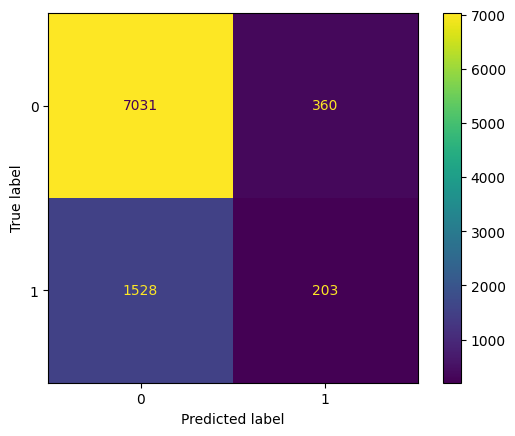

In [55]:
preds = model_ens.predict(X_test)
roc = roc_auc_score(y_test, preds)
prec = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print('ROC AUC: ', roc)
print('F1 score: ', f1)
print('Accuracy: ', accuracy)
print('Precision: ', prec)
print('Recall: ', recall)
cm = confusion_matrix(y_test, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1 ])
disp.plot()

Анализ результатов

Нужно добавить метрики, по которым ты будешь оценивать эффективность той или иной модели

- Accuracy
- ROC AUC Score
- Confusion matrix
- Precision
- Recall
- Precision-Recall curve
- F1 score
- Log loss

Все модели, их параметры и результаты метрик сохраняй себе в каком-то виде.

Так же не забывай отслеживать сколько какая модель затрачивает времени на обучение/поиск гиперпараметров

Такую инфо можно сохранять используя dict, после этого сохранять в json.

Пример:

```Python
model_states = {
    "my_model_name_30_01_2024.pth": {
        "model": "XGBoost",
        "learning_time_sec": 900,
        "hyperparams": {
            "params1": 1,
            "params2": 2,
            "params3": 3
        },
        "scores": {
            "roc_auc": 0.5,
            "f1": 0.6,
            "accuracy": 0.7
        },
        "data": {
            "columns": ["col1", "col2", "col3"],
            "target": ["col4"]
        }
    },
    
    "my_model_version2_30_01_2024.pth": {}
}
```

In [44]:
from sklearn.model_selection import TimeSeriesSplit

In [56]:
tscv = TimeSeriesSplit()
tscv.split(epic_df.drop('winner', axis=1), epic_df['winner'])

<generator object TimeSeriesSplit.split at 0x0000014FF34908E0>

In [57]:
x = epic_df.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish','winner'], axis=1).reset_index().drop('index', axis=1)
y = epic_df['winner'].reset_index().drop('index', axis=1)

ROC AUC:  0.6921581722051205
F1 score:  0.5157096424702059
Accuracy:  0.7932947976878613
Precision:  0.5157096424702059
Recall:  0.5157096424702059
//////////////////////////////////////////////////////////////
lot_amount  :  0.034885846
tender_VAT  :  0.03349025
lot_quantity  :  0.04243039
guarantee  :  0.028594613
category  :  0.03895724
price_offer_before_auction  :  0.11829537
days_to_get_paid  :  0.040600054
prepayment  :  0.035195213
postpayment  :  0.051058397
prepayment_percentage  :  0.034653753
postpayment_percentage  :  0.09356086
amount_of_splits  :  0.03707347
days_to_deliver  :  0.046270397
category_participation count  :  0.04892911
tender_buy_type_Не вказано  :  0.052885775
tender_buy_type_Послуги  :  0.0
tender_buy_type_Товари  :  0.035761047
tender_procedure_Інше  :  0.05292692
tender_procedure_Запит (ціни) пропозицій  :  0.0
tender_procedure_Спрощена закупівля  :  0.17443126
//////////////////////////////////////////////////////////////
ROC AUC:  0.5840500601628456
F

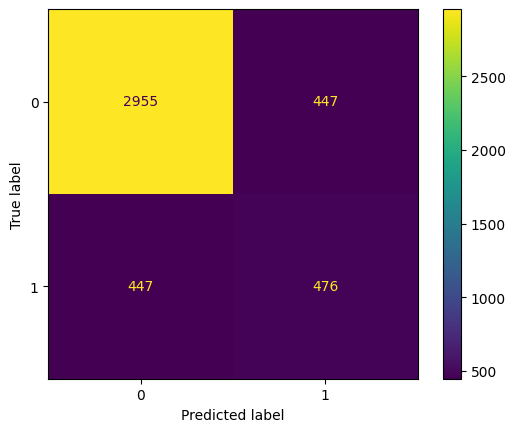

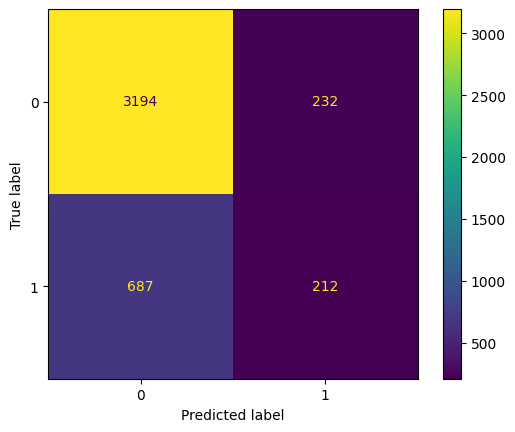

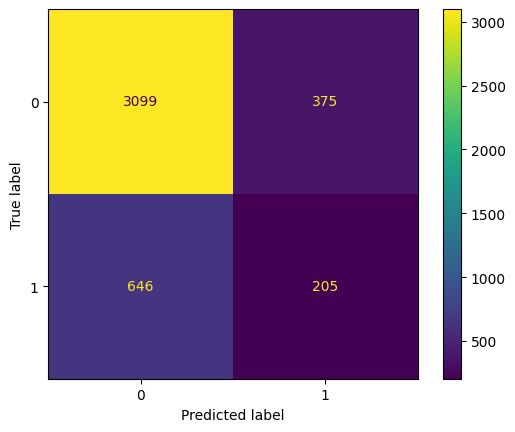

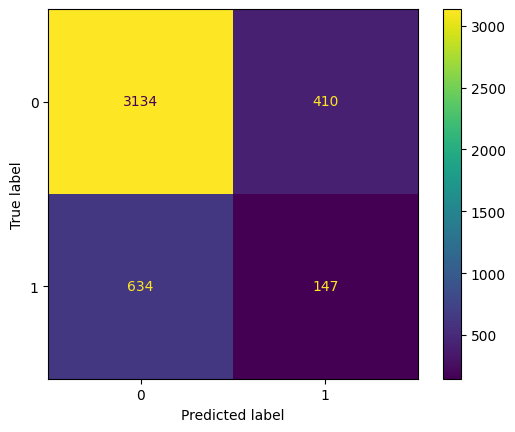

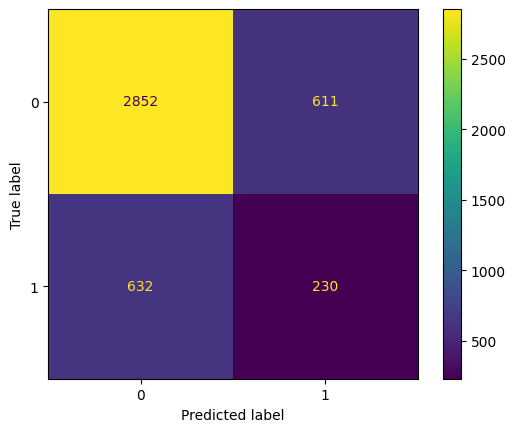

In [81]:
k = 0
for i, j in tscv.split(x, y):
    if(k <= 2):
        xgc.fit(x.iloc[i], y.iloc[i])
    k+=1
    preds = xgc.predict(x.iloc[j])
    roc = roc_auc_score(y.iloc[j], preds)
    prec = precision_score(y.iloc[j], preds)
    recall = recall_score(y.iloc[j], preds)
    f1 = f1_score(y.iloc[j], preds)
    accuracy = accuracy_score(y.iloc[j], preds)
    print('ROC AUC: ', roc)
    print('F1 score: ', f1)
    print('Accuracy: ', accuracy)
    print('Precision: ', prec)
    print('Recall: ', recall)
    print('//////////////////////////////////////////////////////////////')
    cm = confusion_matrix(y.iloc[j], preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1 ])
    disp.plot()
    for i in range(len(xgc.feature_names_in_)):
        print(xgc.feature_names_in_[i],' : ',xgc.feature_importances_[i])
    print('//////////////////////////////////////////////////////////////')

In [70]:
val_df = df[df['supplier_okpo'].isin(['43977041', '43808856', '43709245', '21633086', '39821153', '25551379'])]